In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os, sys
import galsim

sys.path.insert(0,'../scripts/tools_for_VAE/')
import tools_for_VAE
from tools_for_VAE import utils, plot
from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils
from tools_for_VAE.utils import load_vae_conv, denorm, norm

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import warnings
warnings.filterwarnings("ignore")

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
#%run ../scripts/Images_generation/cosmos_generation.py

In [3]:
training_or_test = 'test'
data_dir = '/sps/lsst/users/barcelin/data/isolated_galaxies/centered/' + training_or_test
root = 'galaxies_isolated_20191024'

In [4]:
dfs = []
for i in range(1):
    dfs.append(pd.read_csv(os.path.join(data_dir, root+'_{}_data.csv'.format(i))))
df = dfs[0]
for df2 in dfs[1:]:
    df = df.append(df2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
nb_blended_gal               10000 non-null int64
SNR                          10000 non-null float64
SNR_peak                     10000 non-null float64
redshift                     10000 non-null float64
moment_sigma                 10000 non-null float64
e1                           10000 non-null float64
e2                           10000 non-null float64
mag                          10000 non-null float64
mag_ir                       10000 non-null float64
closest_x                    0 non-null float64
closest_y                    0 non-null float64
closest_redshift             0 non-null float64
closest_moment_sigma         0 non-null float64
closest_e1                   0 non-null float64
closest_e2                   0 non-null float64
closest_mag                  0 non-null float64
closest_mag_ir               0 non-null float64
blendedness_total_lsst       0 non-null fl

In [6]:
df.head()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,closest_moment_sigma,closest_e1,closest_e2,closest_mag,closest_mag_ir,blendedness_total_lsst,blendedness_closest_lsst,blendedness_aperture_lsst,idx_closest_to_peak,n_peak_detected
0,1,1048.061796,0.510847,0.3068,3.345970,0.429479,-0.537024,23.090091,-3.730106,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,1,60.969725,0.036068,1.6113,2.175268,-0.121809,0.077567,26.868364,-1.418402,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,1,330.892748,0.251758,0.2629,1.823595,0.505695,-0.147924,25.104066,-1.679262,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,1,79.629374,0.051692,0.8291,2.100793,0.495612,-0.493724,26.530549,-1.657671,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,1,58.045023,0.041426,1.2307,1.808643,0.245750,-0.179226,27.089047,-1.122494,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


In [7]:
df.describe()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,closest_moment_sigma,closest_e1,closest_e2,closest_mag,closest_mag_ir,blendedness_total_lsst,blendedness_closest_lsst,blendedness_aperture_lsst,idx_closest_to_peak,n_peak_detected
count,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,10000.0
mean,1.0,151.928500,0.103267,1.077473,2.040545,-0.000780,0.001388,26.629442,-1.501314,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
std,0.0,370.435397,0.292517,0.789826,0.456603,0.290752,0.289806,1.202432,1.317500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
min,1.0,10.577214,0.005381,0.006500,1.488476,-1.615451,-1.615525,20.037094,-7.306114,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
25%,1.0,38.357899,0.027232,0.502425,1.727748,-0.178864,-0.172387,26.141853,-2.250969,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
50%,1.0,59.619506,0.041439,0.868300,1.919176,0.000433,0.000298,26.964841,-1.304456,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
75%,1.0,111.859206,0.074380,1.371000,2.196154,0.175209,0.177408,27.479360,-0.560245,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
max,1.0,6821.536476,7.657522,5.208000,5.651823,1.753890,1.538201,27.999770,0.946252,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0


6821.536476452738

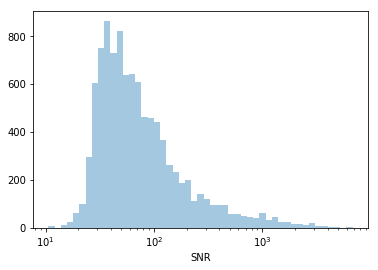

In [8]:
sns.distplot(df['SNR'], bins=np.geomspace(np.min(df['SNR']), np.max(df['SNR']), 50), kde=False)
plt.xscale('log')
plt.xlabel('SNR')
np.max(df['SNR'])

In [9]:
df['e'] = np.sqrt(df['e1']**2+df['e2']**2)

1.6582713758474996 3.1394287438288004


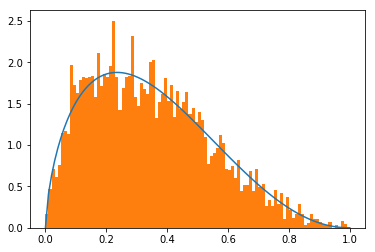

In [10]:
import scipy

e_fit = df['e'][np.logical_and(0.<df['e'], df['e']<1.)]
a, b,_,_ = scipy.stats.beta.fit(e_fit, floc=0., fscale=1.)
print(a, b)

xx = np.linspace(0,1,100)
plt.plot(xx,scipy.stats.beta.pdf(xx, a=a, b=b))
_ = plt.hist(e_fit, bins=100, range=[0,1], normed=True)

In [89]:
training_or_test = 'validation/'
data_dir = '/sps/lsst/users/barcelin/data/isolated_galaxies/centered/'+training_or_test
root = 'galaxies_isolated_20191024'
count = 0

In [90]:
def compute_e(galaxies):
    PSF = galsim.Kolmogorov(fwhm=0.65)
    r_band = 6
    bands = [0,1,2,3,4,5,6,7,8,9]
    pix_scale = 0.2

    psf_image = PSF.drawImage(nx=64, ny=64, scale=pix_scale)
    e = []
    weight = []
    error_list = []
    denormed_gal = denorm(galaxies[:,0], bands, n_years = 5)
    #denormed_gal = galaxies[:,0]
    for i in range(len(galaxies)):
        #print(i)
        temp_weight = 0.
        try :
            gal_image = galsim.Image(denormed_gal[i][r_band,:,:])
            gal_image.scale = pix_scale

            # Measurements of shapes
            shear_est = 'KSB'
            res = galsim.hsm.EstimateShear(gal_image, psf_image, shear_est=shear_est, strict=True)
            g = np.sqrt(res.corrected_g1**2+res.corrected_g2**2)

            if g < 1.:
                #error_list.append(i)
                #pass
                temp_weight = 1. / (scipy.stats.beta.pdf(g, a=a, b=b) + 0.05)
            else:
                error_list.append(i)
        except:
            pass
        
        weight.append(temp_weight)
    return np.array(weight)#,error_list #np.array(e), count, error_list

In [91]:
weights = []
bands = [0,1,2,3,4,5,6,7,8,9]
for i in range (1):
    galaxies = np.load(os.path.join(data_dir, root+'_{}_images.npy'.format(i)), mmap_mode = 'c')
    
    # Compute e_beta
    weights = compute_e(galaxies)
    np.save(data_dir+str('weights_{}.npy'.format(i+1)),weights)

In [84]:
weights.shape

(10000,)

In [85]:
print(data_dir+str('weights_{}.npy'.format(i+1)))

/sps/lsst/users/barcelin/data/isolated_galaxies/centered/training/weights_1.npy


In [86]:
np.save(data_dir+str('weights_{}.npy'.format(i+1)),weights)
#np.save(data_dir+'/cropped/'+str('images_cropped_v2_{}.npy'.format(i+1)),new_galaxies)

14.283966921692004

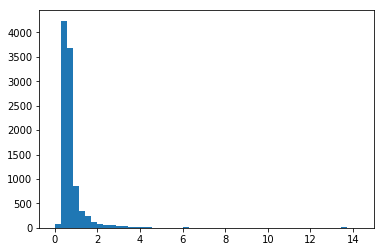

In [74]:
_ = plt.hist(weights, bins = 50)
np.max(weights)